In [1]:
import numpy as np
from numpy.random import randn
from scipy.stats import norm as ndist
from numpy.linalg import norm
from numpy import log, zeros, eye, array
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as MVN

from RWM import RWM
from tangential_hug_functions import Hug, HugTangential

In [2]:
dy = 1
dθ = 2
F = lambda θ: θ[1]**2 + (θ[0]**2) * (θ[0]**2 - 0.5)
y_obs = 1

In [3]:
sample_prior   = lambda: randn(2)
prior_density  = lambda x: MVN(zeros(2), eye(2)).pdf(x)
prior_log_dens = lambda x: MVN(zeros(2), eye(2)).logpdf(x)
prior_neg_log_dens = lambda x: -prior_log_dens(x)
grad_log_prior = lambda x: -x
grad_F = lambda θ: array([4*θ[0]**3 - θ[0], 2*θ[1]])

In [6]:
θ0 = sample_prior()
N = 50000

In [16]:
σ = 0.1

In [17]:
def log_posterior(θ, y=y_obs, σ=σ):
    return prior_log_dens(θ) - norm(y - F(θ))**2 / (2*σ**2) - 1*log(σ)

def grad_log_post(θ, y=y_obs, σ=σ):
    return grad_log_prior(θ) + (y - F(θ))*grad_F(θ) / (σ**2)

In [18]:
# First value
σ1 = 0.5
ϵ1 = σ1
log_post1 = lambda θ: log_posterior(θ, σ=σ1)
samples1, acc1 = RWM(θ0, ϵ1, N, log_post1)

# Second value
σ2 = 0.1
ϵ2 = σ2
log_post2 = lambda θ: log_posterior(θ, σ=σ2)
samples2, acc2 = RWM(θ0, ϵ2, N, log_post2)

# Third value
σ3 = 0.02
ϵ3 = σ3
log_post3 = lambda θ: log_posterior(θ, σ=σ3)
samples3, acc3 = RWM(θ0, ϵ3, N, log_post3)

In [19]:
q = MVN(zeros(2), eye(2))
T = 5.0
B = 5
grad_log_post1 = lambda θ: grad_log_post(θ, σ=σ1)
grad_log_post2 = lambda θ: grad_log_post(θ, σ=σ2)
grad_log_post3 = lambda θ: grad_log_post(θ, σ=σ3)
samples_hug3, acc_hug3 = Hug(θ0, T, B, 2000, q, log_post3, grad_log_post3)

In [20]:
samples_thug3, acc_thug3 = HugTangential(θ0, T, B, 2000, 0.9, q, log_post3, grad_log_post3)

# Graham Notebook

In [572]:
import time
import inspect
from functools import partial
from itertools import product
import matplotlib.patches as mpatches
from matplotlib.colors import to_hex

In [2]:
### fix collections, see
# https://stackoverflow.com/questions/72032032/importerror-cannot-import-name-iterable-from-collections-in-python
import collections.abc
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping

In [3]:
import symnum.numpy as snp
from symnum import (
    numpify, named_array, jacobian, grad, 
    vector_jacobian_product, matrix_hessian_product)
import numpy as np
import sympy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from ipywidgets import interact, fixed, Dropdown
from IPython.display import Javascript
import arviz
import mici

In [4]:
import os
ON_BINDER = 'BINDER_SERVICE_HOST' in os.environ

plt.rcParams.update({
    'mathtext.fontset': 'cm',
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 10,
    'axes.linewidth': 0.5,
    'lines.linewidth': 1.,
    'axes.labelpad': 2.,
    'figure.dpi': 100,
    'figure.figsize': (6, 6),
    'legend.frameon': False,
    'animation.html': 'html5'
})

dens_cmap = mcolors.LinearSegmentedColormap.from_list(
    'whiteblue', [np.array((1.000, 1.000, 1.000, 1.)),
                  np.array((0.419, 0.682, 0.840, 1.)),
                  np.array((0.031, 0.188, 0.420, 1.))])

seed = 20200310
rng = np.random.default_rng(seed)

In [5]:
ON_COLAB = False
# To always use interactive plots by default comment the first line below 
# and uncomment the second
default_plot_type = 'Static' if not (ON_COLAB or ON_BINDER) else 'Interactive'
# default_plot_type = 'Interactive'
        
plot_type = Dropdown(value=default_plot_type, description='Plot type', 
                 options=['Interactive', 'Static'])

def interact_or_grid(plot_function, figsize=(12, 12), subplot_kw=None, **kwargs):
    display(plot_type)
    grid_params = kwargs.pop('grid_params', ('y', 'σ'))
    params = {k: v[0] if plot_type.value == 'Interactive' else v[1] 
              for k, v in kwargs.items()}
    if plot_type.value == 'Interactive':
        interact(plot_function, **params, ax=fixed(None))
    else:
        fig, axes = plt.subplots(
            len(params[grid_params[0]]), len(params[grid_params[1]]), 
            figsize=figsize, subplot_kw=subplot_kw)
        grid_param_0_vals = params.pop(grid_params[0])
        grid_param_1_vals = params.pop(grid_params[1])
        for (p0, p1), ax in zip(product(grid_param_0_vals, grid_param_1_vals), 
                                axes.flat):
            plot_function(
                **{grid_params[0]: p0, grid_params[1]: p1}, **params, ax=ax)
            ax.set_title(fr'${grid_params[0]}={p0}, {grid_params[1]}={p1}$')
        fig.tight_layout()

In [6]:
dim_θ = 2
dim_y = 1

@numpify(dim_θ)
def forward_func(θ):
    return snp.array([θ[1]**2 + 3 * θ[0]**2 * (θ[0]**2 - 1)])

In [7]:
θ_grid = np.stack(
    np.meshgrid(np.linspace(-2, 2, 201), np.linspace(-2, 2, 201))
)
f_grid = forward_func(θ_grid)

In [8]:
@numpify(dim_θ, None, None)
def neg_log_posterior_dens(θ, σ, y):
    return (snp.sum(θ**2, 0) + snp.sum((y - forward_func(θ))**2, 0) / σ**2) / 2

In [563]:
def create_fig_if_none(ax, **fig_kw):
    if ax is None:
        fig, ax = plt.subplots(**fig_kw)
    else:
        fig = ax.figure
    return fig, ax

def plot_posterior_density(σ=0.1, y=1., ax=None, returnmesh=False):
    fig, ax = create_fig_if_none(ax)
    if not returnmesh:
        ax.pcolormesh(θ_grid[0], θ_grid[1],
                      np.exp(-neg_log_posterior_dens(θ_grid, σ, y)), 
                      cmap=dens_cmap)
        ax.set(xlabel=r'$\theta_0$', ylabel=r'$\theta_1$')
        return fig, ax
    else:
        densmesh = ax.pcolormesh(θ_grid[0], θ_grid[1],
                      np.exp(-neg_log_posterior_dens(θ_grid, σ, y)), 
                      cmap=dens_cmap)
        ax.set(xlabel=r'$\theta_0$', ylabel=r'$\theta_1$')
        return fig, ax, densmesh

In [10]:
def split_into_integer_parts(n, m):
    return [round(n / m)] * (m - 1) + [n - round(n / m) * (m - 1)]

def grid_on_interval(interval, n_points, cosine_spacing=False):
    if cosine_spacing:
        # Use non-linear spacing with higher density near endpoints
        ts =  ((1 + np.cos(np.linspace(0, 1, n_points) * np.pi)) / 2)
    else:
        ts = np.linspace(0, 1, n_points)
    # If open interval space over range [left + eps, right - eps]
    eps = 10 * np.finfo(np.float64).eps
    left = (float(interval.left) + eps if interval.left_open 
            else float(interval.left))
    right = (float(interval.right) - eps if interval.right_open 
             else float(interval.right))
    return left + ts * (right - left)


In [11]:
def solve_for_limiting_manifold(y, n_points=200, cosine_spacing=False):
    assert n_points % 2 == 0, 'n_points must be even'
    θ = named_array('θ', 2)
    # solve F(θ) = y for θ[1] in terms of θ[0]
    θ_1_gvn_θ_0 = sympy.solve(forward_func(θ)[0] - y, θ[1])
    # find interval(s) over which θ[0] gives real θ[1] solutions
    θ_0_range = sympy.solveset(
        θ_1_gvn_θ_0[0]**2 > 0, θ[0], domain=sympy.Reals)
    θ_0_intervals = (
        θ_0_range.args if isinstance(θ_0_range, sympy.Union) 
        else [θ_0_range])
    # create  grid of values over valid θ[0] interval(s)
    n_intervals = len(θ_0_intervals)
    θ_0_grids = [
        grid_on_interval(intvl, n_pt + 1, cosine_spacing)
        for intvl, n_pt in zip(
            θ_0_intervals, 
            split_into_integer_parts(n_points // 2, n_intervals))]
    # generate NumPy function to calculate θ[1] in terms of θ[0]
    solve_func = sympy.lambdify(θ[0], θ_1_gvn_θ_0)
    manifold_points = []
    for θ_0_grid in θ_0_grids:
        # numerically calculate +/- θ[1] solutions over θ[0] grid
        θ_1_grid_neg, θ_1_grid_pos = solve_func(θ_0_grid)
        # stack θ[0] and θ[1] values in to 2D array in anticlockwise order
        manifold_points.append(np.stack([
            np.concatenate([θ_0_grid, θ_0_grid[-2:0:-1]]),
            np.concatenate([θ_1_grid_neg, θ_1_grid_pos[-2:0:-1]])
        ], -1))
    return manifold_points

In [564]:
def plot_limiting_manifold(y, ax=None, num_points=200, lw=1., color='C1'):
    manifold_points = solve_for_limiting_manifold(
        y, num_points, cosine_spacing=True)
    fig, ax = create_fig_if_none(ax)
    # repeat first point to close loop by duplicating index
    for component in manifold_points:
        indices = np.arange(component.shape[0] + 1) % component.shape[0]
        line, = ax.plot(component[indices, 0], 
                        component[indices, 1], '-', color=color, lw=lw)
    return fig, ax, line

def plot_posterior_density_and_limiting_manifold(σ=0.1, y=1, ax=None, lw=1., color='C1', returnartist=True):
    if not returnartist:
        fig, ax = plot_posterior_density(σ, y, ax)
        plot_limiting_manifold(y=y, ax=ax, lw=lw, color=color)
        return fig, ax
    else:
        fig, ax, densmesh = plot_posterior_density(σ, y, ax, returnmesh=True)
        fig, ax, line = plot_limiting_manifold(y=y, ax=ax, lw=lw, color=color, )
        return fig, ax, line, densmesh

In [29]:
grad_neg_log_posterior_dens = grad(neg_log_posterior_dens)

In [30]:
def plot_posterior_density_and_grad_field(σ=0.1, y=1, ax=None):
    fig, ax = plot_posterior_density_and_limiting_manifold(σ, y, ax)
    θ_grid_grad = θ_grid[:, ::10, ::10]
    grad_field = -grad_neg_log_posterior_dens(θ_grid_grad, σ, y)
    grad_field_norm = np.sum(grad_field**2, 0)**0.5
    grad_field[:, grad_field_norm >= 1e-8] /= grad_field_norm[grad_field_norm >= 1e-8]
    ax.quiver(*θ_grid_grad, *(grad_field), angles='xy')
    return fig, ax

In [31]:
grad_and_val_neg_log_posterior_dens = grad(
    neg_log_posterior_dens, return_aux=True)

In [139]:
y = 1

In [341]:
# state = mici.states.ChainState(
#     pos=rng.standard_normal(dim_θ), mom=None, dir=1)
#state = mici.states.ChainState(pos=solve_for_limiting_manifold(y, n_points=2)[-1][:1, :].flatten(), mom=None, dir=1)
state = mici.states.ChainState(pos=np.array([0.0, -1.0]), mom=None, dir=1)
state.mom = system.sample_momentum(state, rng)

In [342]:
σ = 0.1

In [343]:
system = mici.systems.EuclideanMetricSystem(
    neg_log_dens=partial(neg_log_posterior_dens, σ=σ, y=y),
    grad_neg_log_dens=partial(grad_and_val_neg_log_posterior_dens, σ=σ, y=y)
)
integrator = mici.integrators.LeapfrogIntegrator(system, step_size=0.05)
sampler = mici.samplers.StaticMetropolisHMC(system, integrator, rng, n_step=20)
final_state, trace, stats = sampler.sample_chain(n_iter=2000, init_state=state)

Chain 1/1: 100%|██████████|2000/2000 [00:00<00:00, 2495.30it/s, accept_stat=0.693]

In [344]:
# pack it up into a noice function
def hmc_samples(σ, start):
    # System, integrator, sampler
    system = mici.systems.EuclideanMetricSystem(
    neg_log_dens=partial(neg_log_posterior_dens, σ=σ, y=y),
    grad_neg_log_dens=partial(grad_and_val_neg_log_posterior_dens, σ=σ, y=y)
    )
    integrator = mici.integrators.LeapfrogIntegrator(system, step_size=0.05)
    sampler = mici.samplers.StaticMetropolisHMC(system, integrator, rng, n_step=20)
    # Set up the state
    state = mici.states.ChainState(pos=start, mom=None, dir=1)
    state.mom = system.sample_momentum(state, rng)
    # Sample
    final_state, trace, stats = sampler.sample_chain(n_iter=2000, init_state=state)
    return trace

In [345]:
trace1 = hmc_samples(0.5, np.array([0.0, -1.0]))
trace2 = hmc_samples(0.1, np.array([0.0, -1.0]))
trace3 = hmc_samples(0.02, np.array([0.0, -1.0]))

Chain 1/1: 100%|██████████|2000/2000 [00:00<00:00, 2528.64it/s, accept_stat=0.973]

Chain 1/1: 100%|██████████|2000/2000 [00:00<00:00, 2651.96it/s, accept_stat=0.665]

Chain 1/1: 100%|██████████|2000/2000 [00:00<00:00, 2589.14it/s, accept_stat=0.00]

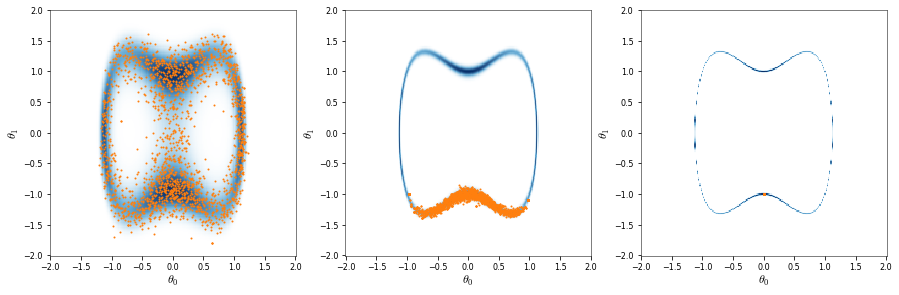

In [169]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
_ = plot_posterior_density(σ=0.5, y=y, ax=ax[0])
ax[0].plot(*trace1['pos'].T, '.', ms=2, color='C1')
ax[0].set_aspect('equal')
_ = plot_posterior_density(σ=0.1, y=y, ax=ax[1])
ax[1].plot(*trace2['pos'].T, '.', ms=2, color='C1')
ax[1].set_aspect('equal')
_ = plot_posterior_density(σ=0.02, y=y, ax=ax[2])
ax[2].plot(*trace3['pos'].T, '.', ms=2, color='C1')
ax[2].set_aspect('equal')

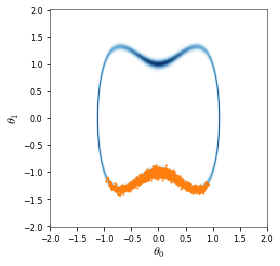

In [152]:
fig, ax = plot_posterior_density(σ=σ, y=y)
ax.plot(*trace['pos'].T, '.', ms=2, color='C1')
ax.set_aspect('equal')
plt.show()

In [119]:
def simulate_proposal(state, system, integrator, rng, n_step=10):
    state.mom = system.sample_momentum(state, rng)
    θ_traj = np.full((n_step + 1, dim_θ), np.nan)
    θ_traj[0] = state.pos[:dim_θ]
    h_init = system.h(state)
    try:
        for s in range(n_step):
            state = integrator.step(state)
            if abs(system.h(state) - h_init) > 1000:
                raise mici.errors.HamiltonianDivergenceError
            θ_traj[s + 1] = state.pos[:dim_θ]
        accepted = rng.uniform() < np.exp(h_init - system.h(state))
    except mici.errors.Error as e:
        accepted = False
    return θ_traj, accepted

In [86]:
def plot_trajectory(ax, θ_traj, accepted):
    ax.plot(θ_traj[:, 0], θ_traj[:, 1], '-o', ms=2, lw=1, 
            color=('limegreen' if accepted else 'red'))
    ax.plot(θ_traj[0, 0], θ_traj[0, 1], 'o', 
            color=('limegreen' if accepted else 'red'))

In [87]:
def plot_hmc_proposals(σ=0.1, ϵ=0.1, y=1, n_step=20, n_particle=4, ax=None):
    system = mici.systems.EuclideanMetricSystem(
                neg_log_dens=partial(neg_log_posterior_dens, σ=σ, y=y),
                grad_neg_log_dens=partial(grad_neg_log_posterior_dens, σ=σ, y=y))
    integrator = mici.integrators.LeapfrogIntegrator(system, step_size=ϵ)
    states = [mici.states.ChainState(pos=θ, mom=None, dir=1) 
              for θ in np.concatenate(solve_for_limiting_manifold(y, n_particle))]
    fig, ax = plot_posterior_density(σ, y, ax)
    rng = np.random.default_rng(seed)
    for state in states:
        plot_trajectory(ax, *simulate_proposal(
            state, system, integrator, rng, n_step))

# HMC

In [88]:
n_sample = 20
n_chain = 4
n_step = 20

σ_grid = np.logspace(-5, 0, 11)
ϵ_grid = np.logspace(-5, 0, 11)

θ_inits = np.concatenate(solve_for_limiting_manifold(y, n_chain))

hmc_av_accept_probs = np.full((σ_grid.shape[0], ϵ_grid.shape[0]), np.nan)

In [89]:
_ = np.seterr(invalid='ignore', over='ignore')

In [90]:
n_sample = 50
n_chain = 10
hmc_av_accept_probs = np.full((σ_grid.shape[0], ϵ_grid.shape[0]), np.nan)
with mici.progressbars.ProgressBar(
        list(enumerate(product(σ_grid, ϵ_grid))), 'Completed') as pb:
    for (i, (σ, ϵ)), _ in pb:
        system = mici.systems.EuclideanMetricSystem(
            neg_log_dens=partial(neg_log_posterior_dens, σ=σ, y=y),
            grad_neg_log_dens=partial(grad_and_val_neg_log_posterior_dens, σ=σ, y=y))
        integrator = mici.integrators.LeapfrogIntegrator(system, step_size=ϵ)
        sampler = mici.samplers.StaticMetropolisHMC(
            system, integrator, rng, n_step=n_step)
        _, _, stats = sampler.sample_chains(
            n_sample, θ_inits, display_progress=False)
        hmc_av_accept_probs.flat[i] = np.concatenate(
            [a for a in stats['accept_stat']]).mean()

Completed: 100%|██████████|121/121 [00:09<00:00, 12.95it/s]

# RM-HMC

In [91]:
@numpify(dim_θ, None)
def metric(θ, σ):
    jac = jacobian(forward_func)(θ)
    return jac.T @ jac / σ**2 + snp.identity(dim_θ)

vjp_metric = vector_jacobian_product(metric, return_aux=True)

In [92]:
def plot_posterior_density_and_riemannian_grad_field(σ=0.1, y=1., ax=None):
    fig, ax = plot_posterior_density_and_limiting_manifold(σ, y, ax)
    θ_grid_grad = θ_grid[:, ::10, ::10]
    metric_field = metric(θ_grid_grad, σ).reshape(
        (dim_θ, dim_θ, -1)).transpose((2, 0, 1))
    grad_field = -grad_neg_log_posterior_dens(
        θ_grid_grad, σ, y).reshape((dim_θ, -1)).T
    grad_field = np.linalg.solve(metric_field, grad_field).T
    grad_field_norm = np.sum(grad_field**2, 0)**0.5
    grad_field[:, grad_field_norm >= 1e-8] /= (
        grad_field_norm[grad_field_norm >= 1e-8])
    ax.quiver(*θ_grid_grad, *(grad_field), angles='xy')
    return fig, ax

In [93]:
def plot_rmhmc_proposals(σ=0.1, ϵ=0.1, y=1, n_step=20, n_particle=4, ax=None):
    system = mici.systems.DenseRiemannianMetricSystem(
                neg_log_dens=partial(neg_log_posterior_dens, σ=σ, y=y),
                grad_neg_log_dens=partial(grad_neg_log_posterior_dens, σ=σ, y=y),
                metric_func=partial(metric, σ=σ), 
                vjp_metric_func=partial(vjp_metric, σ=σ))
    integrator = mici.integrators.ImplicitLeapfrogIntegrator(system, step_size=ϵ)
    states = [mici.states.ChainState(pos=θ, mom=None, dir=1)
              for θ in np.concatenate(solve_for_limiting_manifold(y, n_particle))]
    rng = np.random.default_rng(seed)
    fig, ax = plot_posterior_density(σ, y, ax)
    for state in states:
        plot_trajectory(ax, *simulate_proposal(
            state, system, integrator, rng, n_step))

# C-HMC

In [94]:
@numpify(dim_θ, None, None, None)
def neg_log_lifted_posterior_dens(θ, η, σ, y):
    jac = jacobian(forward_func)(θ)
    return snp.sum(θ**2, 0) / 2 + η**2 / 2 + snp.log(jac @ jac.T + σ**2)[0, 0] / 2

In [95]:
def forward_func_preimage_points(y, n_point):
    t = np.linspace(-1, 1, n_point)
    r, s = -np.cos(np.pi* t), np.sign(t)
    θ_0 = ((1 + (1 + 4 * y / 3)**0.5 - 1e-10) / 2)**0.5 * r
    θ_1 = s * np.sqrt(y - 3 * θ_0**2 * (θ_0**2 - 1))
    return np.stack((θ_0, θ_1), -1)

def manifold_points(σ, y, n_η_vals=50, n_θ_vals=200, η_min_plot=-2., η_max_plot=2.):
    eps = np.finfo(np.float64).eps
    η_grid = np.linspace(η_min_plot + eps,  η_max_plot - eps, n_η_vals)
    θ_points = np.empty((dim_θ,) + (n_η_vals, n_θ_vals))
    η_points = np.tile(η_grid, (n_θ_vals, 1)).T
    for i, η in enumerate(η_grid):
        θ_points[:, i] = forward_func_preimage_points(y - σ * η, n_θ_vals).T
    return θ_points, η_points

# Sample from Lifted Distribution somehow..

Dropdown(description='Plot type', index=1, options=('Interactive', 'Static'), value='Static')

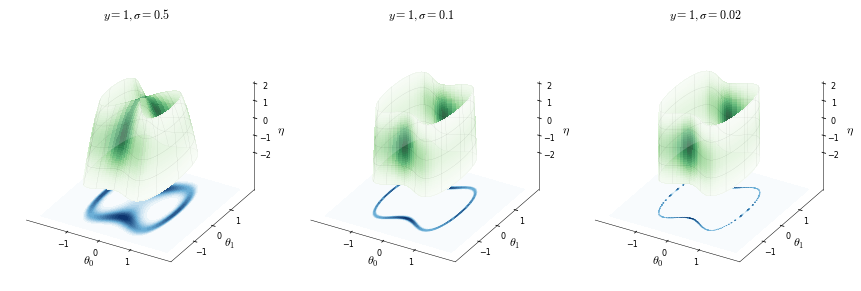

In [275]:
def plot_manifold_and_density(σ=0.1, y=1., azim=-60, elev=30, projection='persp', ax=None):
    fig, ax = create_fig_if_none(ax, subplot_kw={'projection': '3d'})
    θ_points, η_points = manifold_points(σ, y, 40, 80, -2, 2)
    lifted_density_grid = np.exp(-neg_log_lifted_posterior_dens(θ_points, η_points, σ, y))
    density_grid = np.exp(-neg_log_posterior_dens(θ_grid, σ, y))
    # plot lifted density on manifold
    ax.plot_surface(θ_points[0], θ_points[1], η_points, 
                    facecolors=plt.cm.Greens(mcolors.Normalize()(lifted_density_grid)),
                    edgecolor='none', shade=False, cstride=1, rstride=1, 
                    antialiased=False, linewidth=0.0)
    # plot grid 'overlay' over manifold to make shape clearer
    ax.plot_surface(θ_points[0], θ_points[1], η_points, alpha=0.2, color='w',
                    edgecolor=(0, 0, 0, 1), shade=False, cstride=5, rstride=10, 
                    antialiased=True, linewidth=0.1)
    # plot density on original space as filled contour plot below manifold
    ax.contourf(θ_grid[0], θ_grid[1], density_grid, 20, offset=-4, cmap=dens_cmap)
    ax.set(xlabel=r'$\theta_0$', ylabel=r'$\theta_1$', zlabel=r'$\eta$',
           xticks=[-1, 0, 1], yticks=[-1, 0, 1], zticks=[-2, -1, 0, 1, 2],
           zlim=(-4, 2), proj_type=projection)
    ax.tick_params(axis='both', which='major', pad=-2)
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.labelpad = -5
        axis.pane.fill = False
        axis.set_rotate_label(False)
        axis.pane.set_edgecolor('w')
    ax.grid(False)
    ax.view_init(elev, azim)
    
# this is written by me
def plot_lifted_manifold(σ=0.1, y=1., azim=-60, elev=30, projection='persp', ax=None):
    fig, ax = create_fig_if_none(ax, subplot_kw={'projection': '3d'})
    θ_points, η_points = manifold_points(σ, y, 40, 80, -2, 2)
    lifted_density_grid = np.exp(-neg_log_lifted_posterior_dens(θ_points, η_points, σ, y))
    density_grid = np.exp(-neg_log_posterior_dens(θ_grid, σ, y))
    # plot lifted density on manifold
    ax.plot_surface(θ_points[0], θ_points[1], η_points, 
                    facecolors=plt.cm.Greens(mcolors.Normalize()),
                    edgecolor='none', shade=False, cstride=1, rstride=1, 
                    antialiased=False, linewidth=0.0)
    # plot grid 'overlay' over manifold to make shape clearer
    ax.plot_surface(θ_points[0], θ_points[1], η_points, alpha=0.5, color='w',
                    edgecolor=(0, 0, 0, 1), shade=False, cstride=5, rstride=10, 
                    antialiased=True, linewidth=0.1)
    # plot density on original space as filled contour plot below manifold
    ax.contourf(θ_grid[0], θ_grid[1], density_grid, 20, offset=-4, cmap=dens_cmap)
    ax.set(xlabel=r'$\theta_0$', ylabel=r'$\theta_1$', zlabel=r'$\eta$',
           xticks=[-1, 0, 1], yticks=[-1, 0, 1], zticks=[-2, -1, 0, 1, 2],
           zlim=(-4, 2), proj_type=projection)
    ax.tick_params(axis='both', which='major', pad=-2)
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.labelpad = -5
        axis.pane.fill = False
        axis.set_rotate_label(False)
        axis.pane.set_edgecolor('w')
    ax.grid(False)
    ax.view_init(elev, azim)

interact_or_grid(
    plot_manifold_and_density, figsize=(12, 4), subplot_kw={'projection': '3d'},
    σ=[(0.02, 0.5, 0.08), (0.5, 0.1, 0.02)], 
    y=[fixed(1), (1,)], 
    azim=[(-180, 180, 30), -60],
    elev=[(0, 90, 15), 30],
    projection=([('Perspective', 'persp'), ('Orthogonal', 'ortho')], 'ortho'))

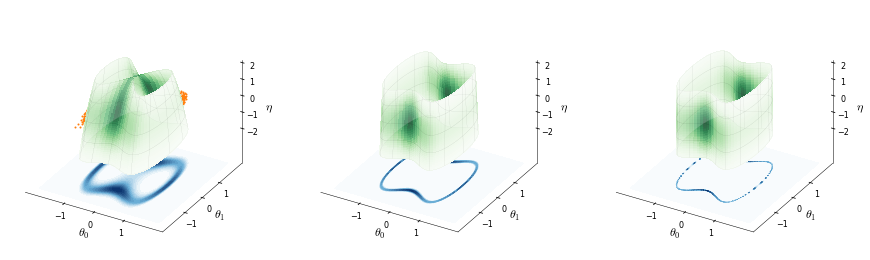

In [240]:
fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(131, projection='3d')
plot_manifold_and_density(σ=0.5, y=1., projection='ortho', ax=ax1)
#ax1.plot(*trace1['pos'].T, '.', ms=2, color='C1')
ax1.plot(*np.hstack((trace1['pos'], np.repeat(0, 2000).reshape(-1, 1))).T, '.', ms=2, color='C1')

ax2 = fig.add_subplot(132, projection='3d')
plot_manifold_and_density(σ=0.1, y=1., projection='ortho', ax=ax2)

ax3 = fig.add_subplot(133, projection='3d')
plot_manifold_and_density(σ=0.02, y=1., projection='ortho', ax=ax3)

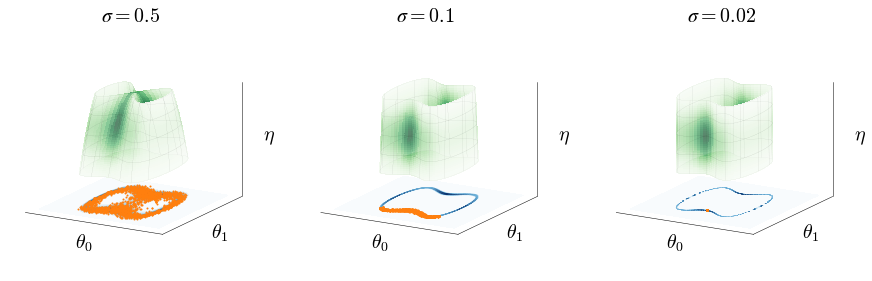

In [516]:
# Samples on standard posterior
TRACE1 = np.hstack((trace1['pos'], np.repeat(-4, 2000).reshape(-1, 1)))
TRACE2 = np.hstack((trace2['pos'], np.repeat(-4, 2000).reshape(-1, 1)))
TRACE3 = np.hstack((trace3['pos'], np.repeat(-4, 2000).reshape(-1, 1)))

# Plot settings
ELEV=16

fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(131, projection='3d')
plot_manifold_and_density(σ=0.5, y=1., projection='ortho', elev=ELEV, ax=ax1)
ax1.plot(*TRACE1.T, '.', ms=2, color='C1', zorder=25)
ax1.set_title(r'$σ = 0.5$', fontsize=20)
ax1.xaxis.label.set_size(fontsize=20)
ax1.set_xticks([])
ax1.yaxis.label.set_size(fontsize=20)
ax1.set_yticks([])
ax1.zaxis.label.set_size(fontsize=20)
ax1.set_zticks([])
#ax1.plot(*TRACE1_LIFTED['pos'].T, '.', ms=2, color='C2', zorder=25)

ax2 = fig.add_subplot(132, projection='3d')
plot_manifold_and_density(σ=0.1, y=1., projection='ortho', elev=ELEV, ax=ax2)
ax2.plot(*TRACE2.T, '.', ms=2, color='C1', zorder=25)
ax2.set_title(r'$σ = 0.1$', fontsize=20)
ax2.xaxis.label.set_size(fontsize=20)
ax2.set_xticks([])
ax2.yaxis.label.set_size(fontsize=20)
ax2.set_yticks([])
ax2.zaxis.label.set_size(fontsize=20)
ax2.set_zticks([])
#ax2.plot(*TRACE2_LIFTED['pos'].T, '.', ms=2, color='C2', zorder=25)

ax3 = fig.add_subplot(133, projection='3d')
plot_manifold_and_density(σ=0.02, y=1., projection='ortho', elev=ELEV, ax=ax3)
ax3.plot(*TRACE3.T, '.', ms=2, color='C1', zorder=25)
ax3.set_title(r'$σ = 0.02$', fontsize=20)
ax3.xaxis.label.set_size(fontsize=20)
ax3.set_xticks([])
ax3.yaxis.label.set_size(fontsize=20)
ax3.set_yticks([])
ax3.zaxis.label.set_size(fontsize=20)
ax3.set_zticks([])
#ax3.plot(*TRACE3_LIFTED['pos'].T, '.', ms=2, color='C2', zorder=25)
plt.savefig("figures/bip_density_and_lifted_density_with_samples.png")
plt.show()

$h(\theta) = \theta_1^2 + 3\theta_0^2(\theta_0^2 - 1)$

$y = h(\theta) + \sigma\eta \qquad \eta\sim\mathcal{N}(0, 1)$

$p_\sigma(\theta\mid y)\propto p(\theta) \mathcal{N}(h(\theta), \sigma^2)$

$p_\sigma(\theta\mid y) = p(\theta) p_\sigma(y\mid \theta) = p(\theta)\displaystyle \int_\mathcal{Y} p_\sigma(y, \eta\mid\theta)d\eta = p(\theta)\int_\mathcal{Y} p_\sigma(y \mid \theta, \eta) p(\eta \mid \theta) d\eta = \int_\mathcal{Y} p_\sigma(y\mid \theta, \eta) p(\theta) p(\eta) d\eta = \int_\mathcal{Y} \delta_{f_\sigma(\theta, \eta)}(y) p(\theta) p(\eta) d\eta$

Therefore $p_\sigma(\theta, \eta\mid y) = \delta_{f_\sigma(\theta, \eta)}(y) p(\theta) p(\eta)$

In [485]:
@numpify(dim_θ+1, None, None)
def lifted_nlpd(ξ, σ, y):
    θ, η = ξ[:2], ξ[-1]
    jac = jacobian(forward_func)(θ)
    return snp.sum(θ**2, 0) / 2 + η**2 / 2 + snp.log(jac @ jac.T + σ**2)[0, 0] / 2

### NO!! The true log-density is with a freaking dirac delta function.
# this is the one wrt the lebesgue measure!!
@numpify(dim_θ+1, None, None)
def lifted_nlpd2(ξ, σ, y):
    θ, η = ξ[:2], ξ[-1]
    yout = θ[1]**2 + 3*(θ[0]**2)*(θ[0]**2 - 1) + σ*η
    return sympy.Piecewise((snp.sum(θ**2, 0)/2 + η**2/2, (yout - y) <= 1e-8), (snp.inf, (yout - y) > 1e-8))

lifted_grad = grad(lifted_nlpd)
lifted_grad2 = grad(lifted_nlpd2)

In [486]:
def hmc_samples_lifted(σ, start):
    # System, integrator, sampler
    system = mici.systems.EuclideanMetricSystem(
    neg_log_dens=partial(lifted_nlpd2, σ=σ, y=y),
    grad_neg_log_dens=partial(lifted_grad2, σ=σ, y=y)
    )
    integrator = mici.integrators.LeapfrogIntegrator(system, step_size=0.05)
    sampler = mici.samplers.StaticMetropolisHMC(system, integrator, rng, n_step=20)
    # Set up the state
    state = mici.states.ChainState(pos=start, mom=None, dir=1)
    state.mom = system.sample_momentum(state, rng)
    # Sample
    final_state, trace, stats = sampler.sample_chain(n_iter=2000, init_state=state)
    return trace

In [487]:
lifted_start = np.hstack((state.pos, np.random.randn()))

In [488]:
TRACE1_LIFTED = hmc_samples_lifted(0.5, lifted_start)
TRACE2_LIFTED = hmc_samples_lifted(0.1, lifted_start)
TRACE3_LIFTED = hmc_samples_lifted(0.02, lifted_start)

Chain 1/1: 100%|██████████|2000/2000 [00:02<00:00, 987.20it/s, accept_stat=0.607]

Chain 1/1: 100%|██████████|2000/2000 [00:01<00:00, 1012.45it/s, accept_stat=0.589]

Chain 1/1: 100%|██████████|2000/2000 [00:01<00:00, 1012.22it/s, accept_stat=0.582]

# Plot of Filamentary Distribution

In [644]:
from scipy.optimize import fsolve
from scipy.stats import multivariate_normal as MVN
from numpy import zeros, eye
from numpy.linalg import norm

In [666]:
θ0 = np.array([0.5, 1.2]) #np.array([1.0, 0.0])
func_to_solve = lambda θ: np.array([*(forward_func(θ) - y), 0.0])
θfound = fsolve(func_to_solve, θ0)
grad_func = lambda θ: np.array([12*θ[0]**3 - 6*θ[0], 2*θ[1]])
norm_grad_func = lambda θ: grad_func(θ) / np.linalg.norm(grad_func(θ))
def find_tang_vec(g):
    v = MVN(zeros(2), eye(2)).rvs()
    vnorm = norm(v)
    v = (v - (v @ g)*g)
    return v / norm(v)

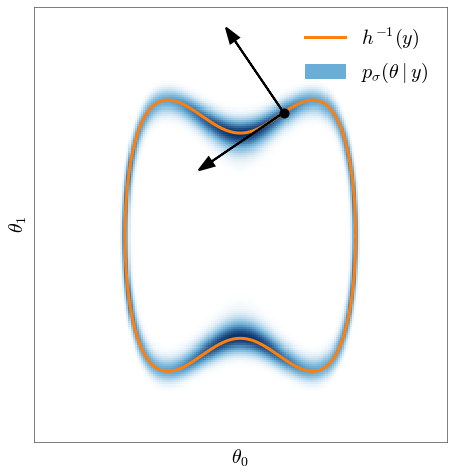

In [673]:
fig, ax = plt.subplots(figsize=(8, 8))
_, _, line, dens = plot_posterior_density_and_limiting_manifold(σ=0.2, y=y, ax=ax, lw=3, color='C1', returnartist=True)
ax.scatter(*θfound, zorder=10, color='black', s=80)
ax.arrow(*θfound, *norm_grad_func(θfound), length_includes_head=True, head_width=0.1, lw=2, color='k')
ax.arrow(*θfound, *find_tang_vec(norm_grad_func(θfound)), length_includes_head=True, head_width=0.1, zorder=15, lw=2, color='k')
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.label.set_size(fontsize=20)
ax.yaxis.label.set_size(fontsize=20)
blue_patch = mpatches.Patch(color=to_hex(dens_cmap(0.5)), label='Density')
ax.legend([line, blue_patch], [r'$h^{-1}(y)$', r'$p_\sigma(\theta\mid y)$'], fontsize=20)
plt.savefig('figures/bip_filamentary_distribution.png')
plt.show()

# Plot Both Manifolds 

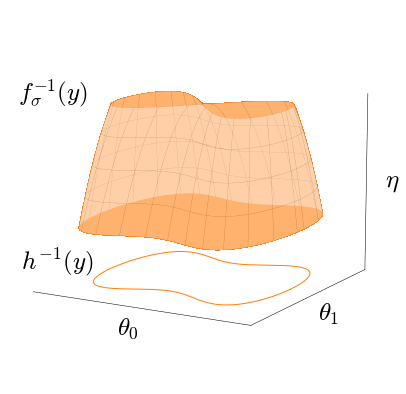

In [851]:
def plot_lifted_manifold(σ=0.1, y=1., azim=-60, elev=30, projection='persp', ax=None):
    fig, ax = create_fig_if_none(ax, subplot_kw={'projection': '3d'})
    θ_points, η_points = manifold_points(σ, y, 40, 80, -2, 2)
    lifted_density_grid = np.exp(-neg_log_lifted_posterior_dens(θ_points, η_points, σ, y))
    density_grid = np.exp(-neg_log_posterior_dens(θ_grid, σ, y))
    # plot lifted density on manifold
    ax.plot_surface(θ_points[0], θ_points[1], η_points, 
                    color='C1',
                    edgecolor='none', shade=False, cstride=1, rstride=1, 
                    antialiased=False, linewidth=0.0)
    # plot grid 'overlay' over manifold to make shape clearer
    ax.plot_surface(θ_points[0], θ_points[1], η_points, alpha=0.4, color='w',
                    edgecolor=(0, 0, 0, 1), shade=False, cstride=3, rstride=10, 
                    antialiased=True, linewidth=0.1)
    # plot density on original space as filled contour plot below manifold
    #ax.contourf(θ_grid[0], θ_grid[1], density_grid, 20, offset=-4, cmap=dens_cmap)
    # repeat first point to close loop by duplicating index
    θs = forward_func_preimage_points(1.0, 500)
    θsaugmented = np.hstack((θs, np.repeat(-4, 500, axis=0).reshape(-1, 1)))
    ax.plot(*θsaugmented.T, color='C1')
    ax.set(xlabel=r'$\theta_0$', ylabel=r'$\theta_1$', zlabel=r'$\eta$',
           xticks=[-1, 0, 1], yticks=[-1, 0, 1], zticks=[-2, -1, 0, 1, 2],
           zlim=(-4, 2), proj_type=projection)
    #ax.tick_params(axis='both', which='major', pad=-2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.xaxis.label.set_size(fontsize=25)
    ax.yaxis.label.set_size(fontsize=25)
    ax.zaxis.label.set_size(fontsize=25)
    ax.text(-2, -1.0, -4.0, r'$h^{-1}(y)$', fontsize=25)
    ax.text(-2, -1.0, 2.0, r'$f^{-1}_{\sigma}(y)$', fontsize=25)
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.labelpad = -5
        axis.pane.fill = False
        axis.set_rotate_label(False)
        axis.pane.set_edgecolor('w')
    ax.grid(False)
    ax.view_init(elev, azim)
    
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
plot_lifted_manifold(σ=0.5, y=1., elev=12, ax=ax)
plt.savefig('figures/bip_both_manifolds.png', transparent=True)
plt.show()

# Plot of Hug Mechanism

In [859]:
# initial position
θ0 = np.array([1.0, 1.0]) #np.array([1.0, 0.0])
func_to_solve = lambda θ: np.array([*(forward_func(θ) - y), 0.0])
θfound = fsolve(func_to_solve, θ0)

In [949]:
# sample velocity
v0 = np.array([0.5, -0.5])
# move to midpoint
δ = 2.0
θ1 = θfound + (δ/2)*v0
y1 = forward_func(θ1)[0]
g1hat = grad_func(θ1) / norm(grad_func(θ1))
v1 = v0 - 2* (v0 @ g1hat)*g1hat
θ2 = θ1 + (δ/2)*v1
θ3 = θ2 + (δ/2)*v1
y3 = forward_func(θ3)[0]
g3hat = grad_func(θ3) / norm(grad_func(θ3))
v2 = v1 - 2* (v1 @ g3hat)*g3hat
θ4 = θ3 + (δ/2)*v2

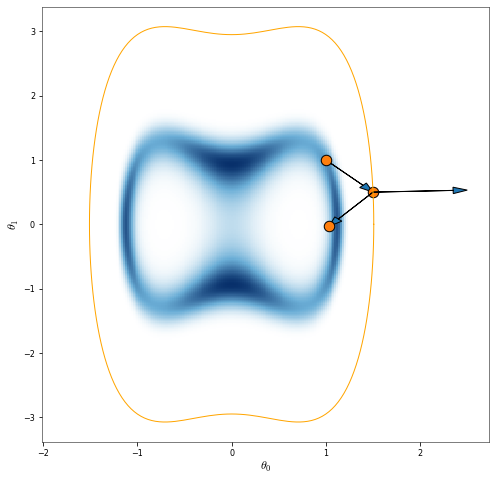

In [912]:
fig, ax = plt.subplots(figsize=(8,8))
# _, _, line, dens = plot_posterior_density_and_limiting_manifold(σ=0.2, y=y, ax=ax, lw=3, color='C1', returnartist=True)
_ = plot_posterior_density(σ=0.5, y=1.0, ax=ax)
ax.arrow(*θfound, *v0, length_includes_head=True, head_width=0.1)
ax.scatter(*θfound, s=110, c='C1', edgecolor='k')
ax.scatter(*θ1, s=110, c='C1', edgecolor='k')
plot_limiting_manifold(y=y1, ax=ax, color='orange')
ax.arrow(*θ1, *g1hat, length_includes_head=True, head_width=0.1)
ax.arrow(*θ1, *v1, length_includes_head=True, head_width=0.1)
ax.scatter(*θ2, s=110, c='C1', edgecolor='k')

#### Only $\theta_0$

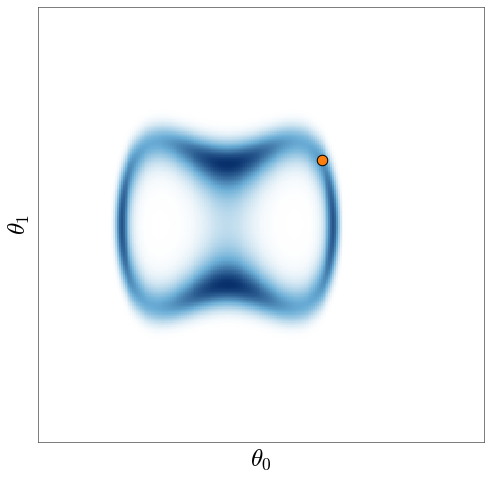

In [970]:
###### θ0 ONLY
fig, ax = plt.subplots(figsize=(8,8))
_ = plot_posterior_density(σ=0.5, y=1.0, ax=ax)
ax.scatter(*θfound, s=110, c='C1', edgecolor='k')
ax.set_xlim((-2.01, 2.724971299060136))
ax.set_ylim((-3.3788449249028822, 3.3788449249028822))
ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.label.set_size(fontsize=25)
ax.yaxis.label.set_size(fontsize=25)
plt.savefig('figures/bip_gif/fig1.png')
plt.show()

#### Sample velocity

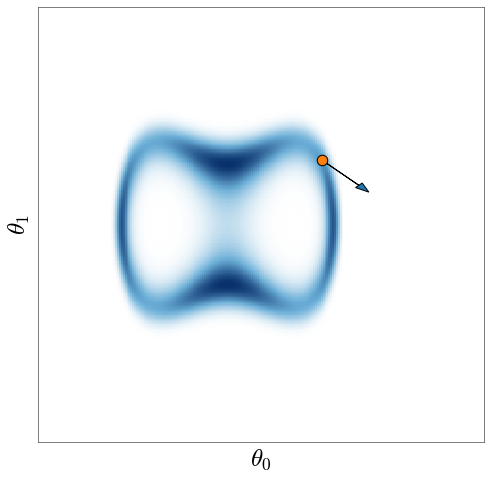

In [971]:
###### θ0 and v0
fig, ax = plt.subplots(figsize=(8,8))
_ = plot_posterior_density(σ=0.5, y=1.0, ax=ax)
ax.arrow(*θfound, *v0, length_includes_head=True, head_width=0.1)
ax.scatter(*θfound, s=110, c='C1', edgecolor='k')
ax.set_xlim((-2.01, 2.724971299060136))
ax.set_ylim((-3.3788449249028822, 3.3788449249028822))
ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.label.set_size(fontsize=25)
ax.yaxis.label.set_size(fontsize=25)
plt.savefig('figures/bip_gif/fig2.png')
plt.show()

#### Move to midpoint

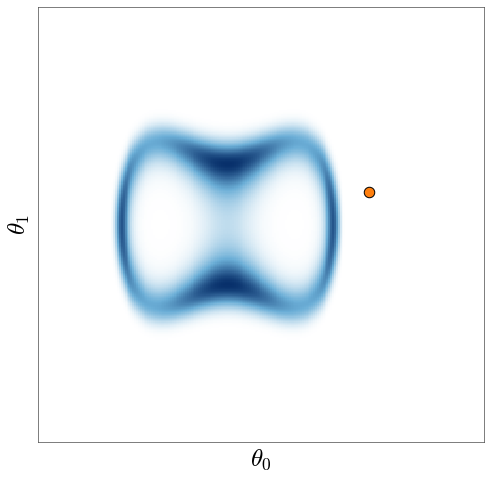

In [972]:
###### θ0, v0, θ1
fig, ax = plt.subplots(figsize=(8,8))
_ = plot_posterior_density(σ=0.5, y=1.0, ax=ax)
#ax.scatter(*θfound, s=110, c='C1', edgecolor='k')
ax.scatter(*θ1, s=110, c='C1', edgecolor='k')
ax.set_xlim((-2.01, 2.724971299060136))
ax.set_ylim((-3.3788449249028822, 3.3788449249028822))
ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.label.set_size(fontsize=25)
ax.yaxis.label.set_size(fontsize=25)
plt.savefig('figures/bip_gif/fig3.png')
plt.show()

#### Compute gradient and bounce velocity

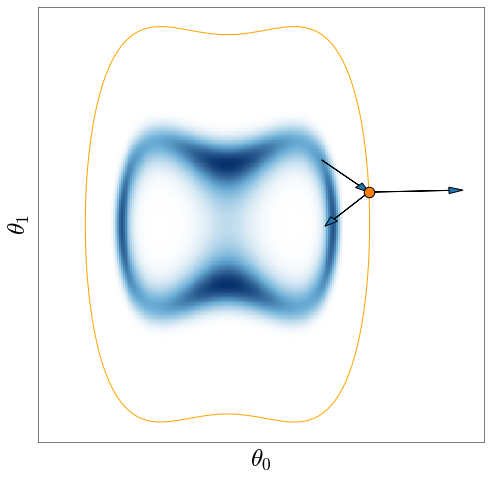

In [973]:
fig, ax = plt.subplots(figsize=(8,8))
_ = plot_posterior_density(σ=0.5, y=1.0, ax=ax)
plot_limiting_manifold(y=y1, ax=ax, color='orange')
ax.arrow(*θfound, *v0, length_includes_head=True, head_width=0.1)
ax.arrow(*θ1, *g1hat, length_includes_head=True, head_width=0.1)
ax.arrow(*θ1, *v1, length_includes_head=True, head_width=0.1)
ax.scatter(*θ1, s=110, c='C1', edgecolor='k', zorder=10)
ax.set_xlim((-2.01, 2.724971299060136))
ax.set_ylim((-3.3788449249028822, 3.3788449249028822))
ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.label.set_size(fontsize=25)
ax.yaxis.label.set_size(fontsize=25)
plt.savefig('figures/bip_gif/fig4.png')
plt.show()

#### Move to new point

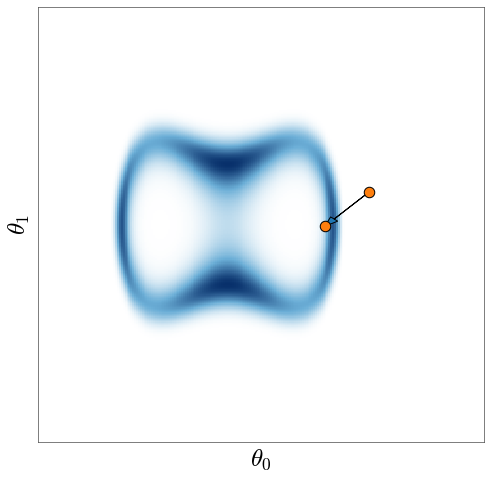

In [974]:
fig, ax = plt.subplots(figsize=(8,8))
_ = plot_posterior_density(σ=0.5, y=1.0, ax=ax)
ax.arrow(*θ1, *v1, length_includes_head=True, head_width=0.1)
ax.scatter(*θ1, s=110, c='C1', edgecolor='k')
ax.scatter(*θ2, s=110, c='C1', edgecolor='k')
ax.set_xlim((-2.01, 2.724971299060136))
ax.set_ylim((-3.3788449249028822, 3.3788449249028822))
ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.label.set_size(fontsize=25)
ax.yaxis.label.set_size(fontsize=25)
plt.savefig('figures/bip_gif/fig5.png')
plt.show()

#### Continue

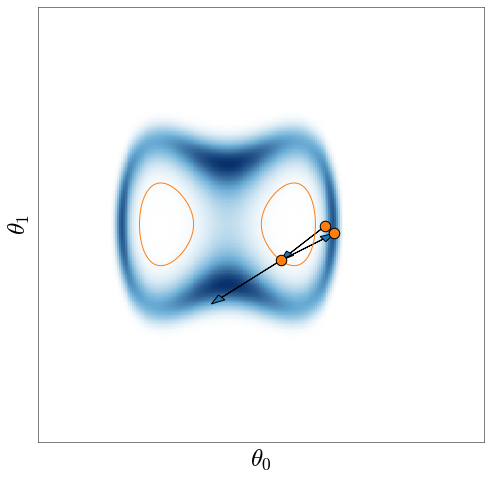

In [975]:
fig, ax = plt.subplots(figsize=(8,8))
_ = plot_posterior_density(σ=0.5, y=1.0, ax=ax)
_ = plot_limiting_manifold(y3, ax=ax)
ax.arrow(*θ2, *v1, length_includes_head=True, head_width=0.1)
ax.arrow(*θ3, *g3hat, length_includes_head=True, head_width=0.1)
ax.arrow(*θ3, *v2, length_includes_head=True, head_width=0.1)
ax.scatter(*θ2, s=110, c='C1', edgecolor='k')
ax.scatter(*θ3, s=110, c='C1', edgecolor='k', zorder=10)
ax.scatter(*θ4, s=110, c='C1', edgecolor='k', zorder=10)
ax.set_xlim((-2.01, 2.724971299060136))
ax.set_ylim((-3.3788449249028822, 3.3788449249028822))
ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.label.set_size(fontsize=25)
ax.yaxis.label.set_size(fontsize=25)
plt.savefig('figures/bip_gif/fig6.png')
plt.show()

#### Accept Reject

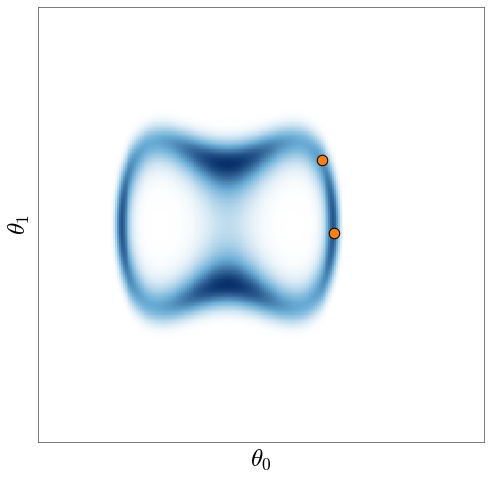

In [976]:
fig, ax = plt.subplots(figsize=(8,8))
_ = plot_posterior_density(σ=0.5, y=1.0, ax=ax)
ax.scatter(*θfound, s=110, c='C1', edgecolor='k')
ax.scatter(*θ4, s=110, c='C1', edgecolor='k', zorder=10)
ax.set_xlim((-2.01, 2.724971299060136))
ax.set_ylim((-3.3788449249028822, 3.3788449249028822))
ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.label.set_size(fontsize=25)
ax.yaxis.label.set_size(fontsize=25)
plt.savefig('figures/bip_gif/fig7.png')
plt.show()

# Plot for Dynamic of Tangential Hug

In [978]:
α = 0.9

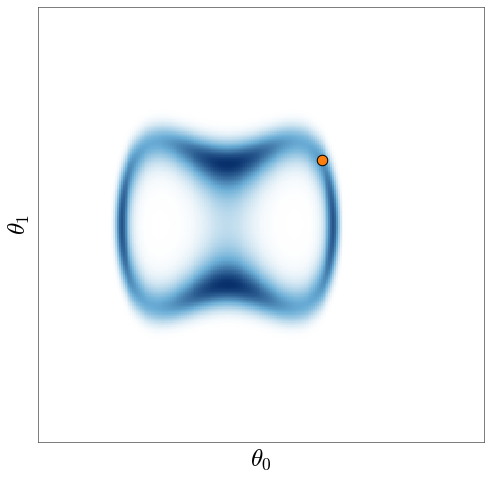

In [1058]:
###### θ0 ONLY
fig, ax = plt.subplots(figsize=(8,8))
_ = plot_posterior_density(σ=0.5, y=1.0, ax=ax)
ax.scatter(*θfound, s=110, c='C1', edgecolor='k')
ax.set_xlim((-2.01, 2.724971299060136))
ax.set_ylim((-3.3788449249028822, 3.3788449249028822))
ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.label.set_size(fontsize=25)
ax.yaxis.label.set_size(fontsize=25)
plt.savefig('figures/bip_gif2/fig1.png')
plt.show()

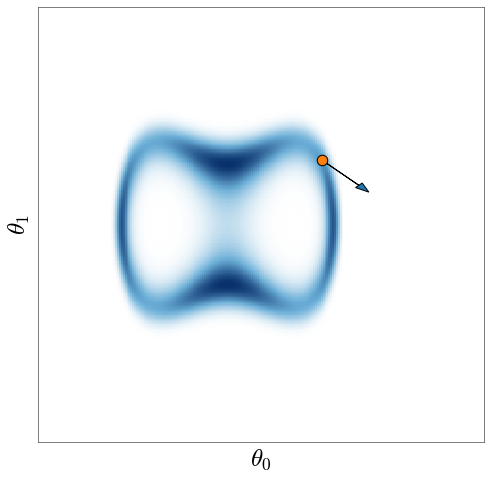

In [980]:
###### θ0 and v0
fig, ax = plt.subplots(figsize=(8,8))
_ = plot_posterior_density(σ=0.5, y=1.0, ax=ax)
ax.arrow(*θfound, *v0, length_includes_head=True, head_width=0.1)
ax.scatter(*θfound, s=110, c='C1', edgecolor='k')
ax.set_xlim((-2.01, 2.724971299060136))
ax.set_ylim((-3.3788449249028822, 3.3788449249028822))
ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.label.set_size(fontsize=25)
ax.yaxis.label.set_size(fontsize=25)
plt.show()

In [1011]:
y0 = forward_func(θfound)[0]
g0hat = grad_func(θfound) / norm(grad_func(θfound))
w0 = v0 - α*(v0@g0hat)*g0hat
θ1t = θfound + (δ/2)*w0
y1t = forward_func(θ1t)[0]
g1hat_t = grad_func(θ1t) / norm(grad_func(θ1t))
w1 = w0 - 2*(w0 @ g1hat_t) * g1hat_t
θ2t = θ1t + (δ/2)*w1
θ3t = θ2t + (δ/2)*w1
y3t = forward_func(θ3t)[0]
g3hat_t = grad_func(θ3t) / norm(grad_func(θ3t))
w3 = w1 - 2 * (w1 @ g3hat_t) * g3hat_t
θ4t = θ3t + (δ/2)*w3

#### Initial point and velocity

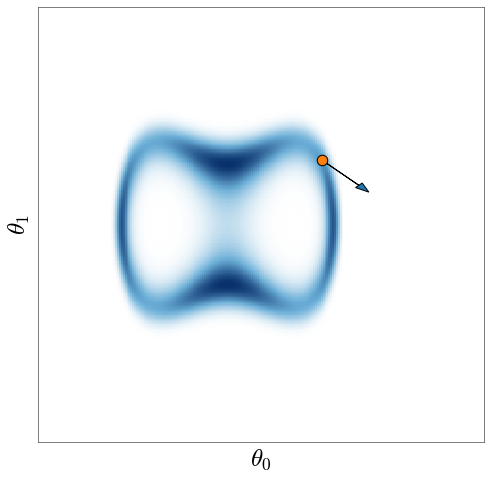

In [1059]:
###### θ0 and v0
fig, ax = plt.subplots(figsize=(8,8))
_ = plot_posterior_density(σ=0.5, y=1.0, ax=ax)
ax.arrow(*θfound, *v0, length_includes_head=True, head_width=0.1)
ax.scatter(*θfound, s=110, c='C1', edgecolor='k')
ax.set_xlim((-2.01, 2.724971299060136))
ax.set_ylim((-3.3788449249028822, 3.3788449249028822))
ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.label.set_size(fontsize=25)
ax.yaxis.label.set_size(fontsize=25)
plt.savefig('figures/bip_gif2/fig1.png')
plt.show()

#### Manifold at the start and gradient and tangential velocity

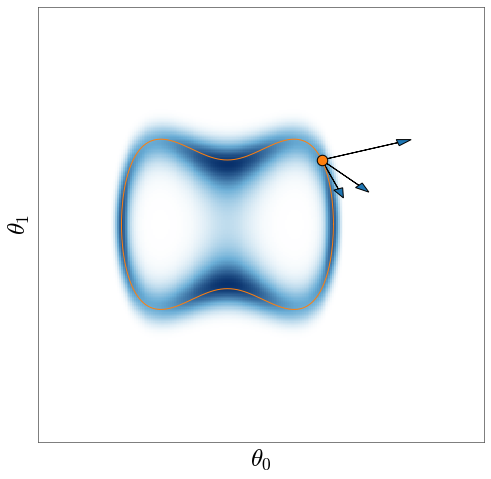

In [1060]:
###### θ0 and v0
fig, ax = plt.subplots(figsize=(8,8))
_ = plot_posterior_density(σ=0.5, y=1.0, ax=ax)
plot_limiting_manifold(y=y0, ax=ax)
ax.arrow(*θfound, *v0, length_includes_head=True, head_width=0.1)
ax.arrow(*θfound, *g0hat, length_includes_head=True, head_width=0.1)
ax.arrow(*θfound, *w0, length_includes_head=True, head_width=0.1)
ax.scatter(*θfound, s=110, c='C1', edgecolor='k', zorder=10)
ax.set_xlim((-2.01, 2.724971299060136))
ax.set_ylim((-3.3788449249028822, 3.3788449249028822))
ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.label.set_size(fontsize=25)
ax.yaxis.label.set_size(fontsize=25)
plt.savefig('figures/bip_gif2/fig2.png')
plt.show()

#### Move to midpoint

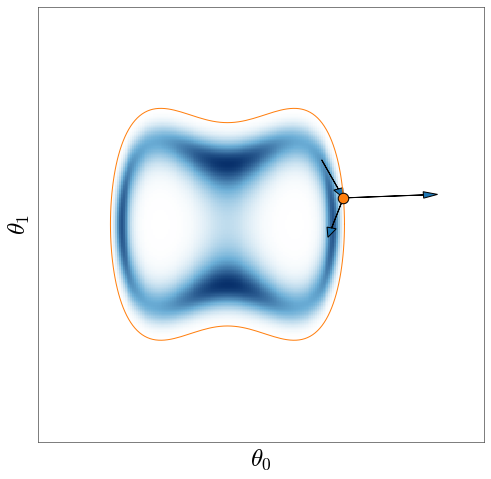

In [1061]:
###### θ0 and v0
fig, ax = plt.subplots(figsize=(8,8))
_ = plot_posterior_density(σ=0.5, y=1.0, ax=ax)
plot_limiting_manifold(y=y1t, ax=ax)
ax.arrow(*θfound, *w0, length_includes_head=True, head_width=0.1)
ax.arrow(*θ1t, *g1hat_t, length_includes_head=True, head_width=0.1)
ax.arrow(*θ1t, *w1, length_includes_head=True, head_width=0.1)
ax.scatter(*θ1t, s=110, c='C1', edgecolor='k', zorder=10)
ax.set_xlim((-2.01, 2.724971299060136))
ax.set_ylim((-3.3788449249028822, 3.3788449249028822))
ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.label.set_size(fontsize=25)
ax.yaxis.label.set_size(fontsize=25)
plt.savefig('figures/bip_gif2/fig3.png')
plt.show()

#### Move to new point

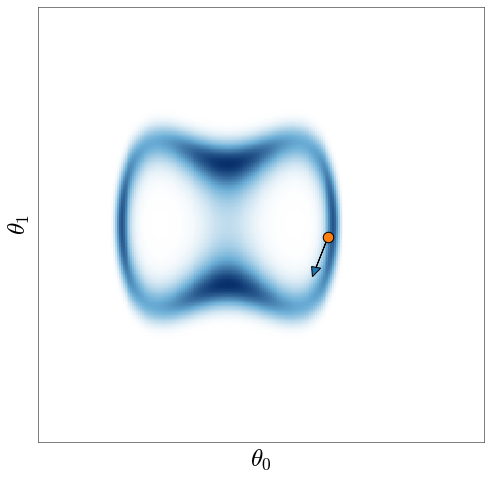

In [1062]:
###### θ0 and v0
fig, ax = plt.subplots(figsize=(8,8))
_ = plot_posterior_density(σ=0.5, y=1.0, ax=ax)
ax.arrow(*θ2t, *w1, length_includes_head=True, head_width=0.1)
ax.scatter(*θ2t, s=110, c='C1', edgecolor='k')
ax.set_xlim((-2.01, 2.724971299060136))
ax.set_ylim((-3.3788449249028822, 3.3788449249028822))
ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.label.set_size(fontsize=25)
ax.yaxis.label.set_size(fontsize=25)
plt.savefig('figures/bip_gif2/fig4.png')
plt.show()

#### Second midpoint

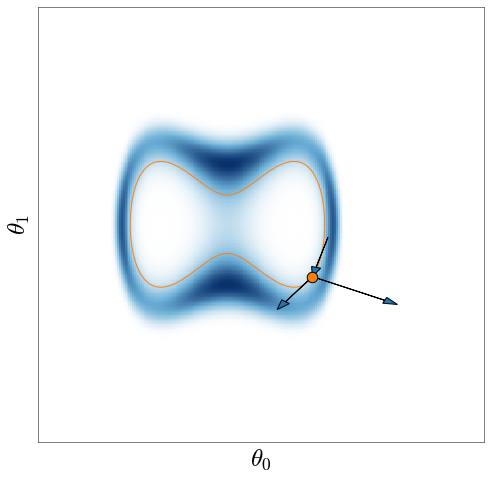

In [1067]:
###### θ0 and v0
fig, ax = plt.subplots(figsize=(8,8))
_ = plot_posterior_density(σ=0.5, y=1.0, ax=ax)
plot_limiting_manifold(y=y3t, ax=ax)
ax.arrow(*θ2t, *w1, length_includes_head=True, head_width=0.1, zorder=10)
ax.arrow(*θ3t, *g3hat_t, length_includes_head=True, head_width=0.1, zorder=10)
ax.arrow(*θ3t, *w3, length_includes_head=True, head_width=0.1, zorder=10)
ax.scatter(*θ3t, s=110, c='C1', edgecolor='k', zorder=20)
ax.set_xlim((-2.01, 2.724971299060136))
ax.set_ylim((-3.3788449249028822, 3.3788449249028822))
ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.label.set_size(fontsize=25)
ax.yaxis.label.set_size(fontsize=25)
plt.savefig('figures/bip_gif2/fig5.png')
plt.show()

#### Final position

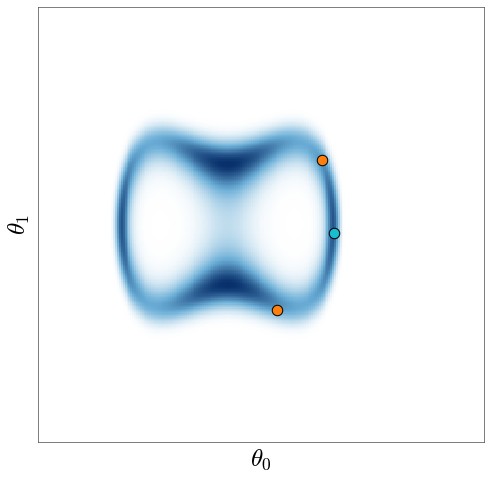

In [1064]:
###### θ0 and v0
fig, ax = plt.subplots(figsize=(8,8))
_ = plot_posterior_density(σ=0.5, y=1.0, ax=ax)
ax.scatter(*θfound, s=110, c='C1', edgecolor='k')
ax.scatter(*θ4t, s=110, c='C1', edgecolor='k')
ax.scatter(*θ4, s=110, c='C9', edgecolor='k')
ax.set_xlim((-2.01, 2.724971299060136))
ax.set_ylim((-3.3788449249028822, 3.3788449249028822))
ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.label.set_size(fontsize=25)
ax.yaxis.label.set_size(fontsize=25)
plt.savefig('figures/bip_gif2/fig6.png')
plt.show()